In [8]:
import pandas as pd
df = pd.concat(map(pd.read_csv, 
                   ['bcsc_risk_factors_summarized1_092020.csv', 
                    'bcsc_risk_factors_summarized2_092020.csv',
                    'bcsc_risk_factors_summarized3_092020.csv'
                    ]
                   ), ignore_index=True).rename(columns={'count': 'metric'})
df = df[df['BIRADS_breast_density'] != 9]
df['BIRADS_breast_density'] = df['BIRADS_breast_density'].map({
    1: 0,
    2: 1,
    3: 2,
    4: 3
})
df['BIRADS_breast_density'] = [1 if x == 3 else 0 for x in df['BIRADS_breast_density']]
df

,year,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx,breast_cancer_history,metric
0,2013,7,1,0,9,3,0,1,2,3,0,0,7
1,2013,7,1,0,9,3,0,1,2,3,1,0,3
2,2013,7,1,0,9,3,0,1,2,4,0,0,6
3,2013,7,1,0,9,3,0,1,2,4,1,0,1
4,2013,7,1,0,9,3,0,1,2,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522335,2013,7,1,0,9,3,0,0,9,9,1,1,1
1522336,2013,7,1,0,9,3,0,1,2,1,0,0,8
1522337,2013,7,1,0,9,3,0,1,2,1,1,0,1
1522338,2013,7,1,0,9,3,0,1,2,2,0,0,12


0.3733135547881912

[0]	validation_0-logloss:0.58424
[1]	validation_0-logloss:0.52852
[2]	validation_0-logloss:0.49736
[3]	validation_0-logloss:0.47939
[4]	validation_0-logloss:0.46881
[5]	validation_0-logloss:0.46294
[6]	validation_0-logloss:0.45966
[7]	validation_0-logloss:0.45817
[8]	validation_0-logloss:0.45757
[9]	validation_0-logloss:0.45778
[10]	validation_0-logloss:0.45845
[11]	validation_0-logloss:0.45926
[12]	validation_0-logloss:0.46036
[13]	validation_0-logloss:0.46154
[14]	validation_0-logloss:0.46281
[15]	validation_0-logloss:0.46414
[16]	validation_0-logloss:0.46544
[17]	validation_0-logloss:0.46667
[18]	validation_0-logloss:0.46792
[19]	validation_0-logloss:0.46927
[20]	validation_0-logloss:0.47048
[21]	validation_0-logloss:0.47163
[22]	validation_0-logloss:0.47284
[23]	validation_0-logloss:0.47391
[24]	validation_0-logloss:0.47508
[25]	validation_0-logloss:0.47626
[26]	validation_0-logloss:0.47733
[27]	validation_0-logloss:0.47839
[28]	validation_0-logloss:0.47945
[29]	validation_0-loglos

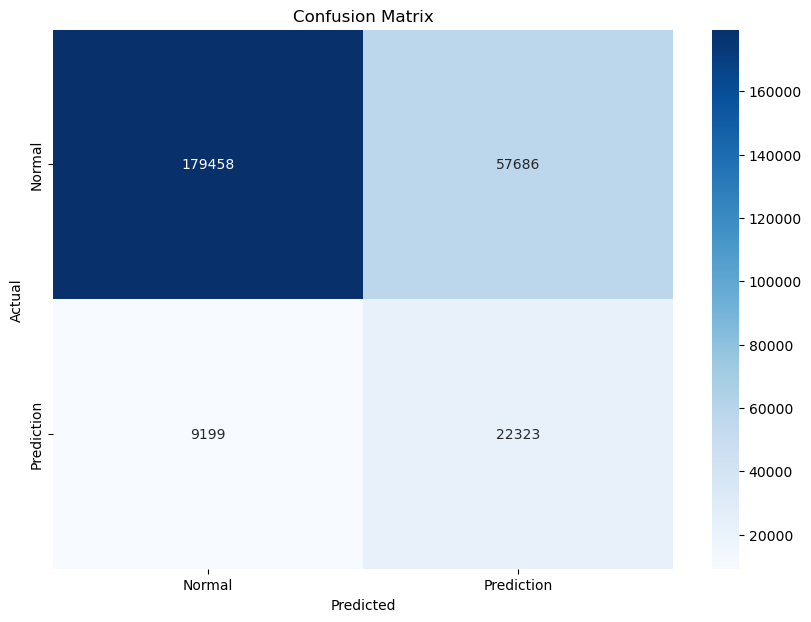

In [10]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


# Preprocess the data: separate features and target
X = df.drop(columns=['BIRADS_breast_density', 'year'])
y = df['BIRADS_breast_density']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

# Initialize the Isolation Forest model
clf = xgb.XGBClassifier(device="cuda",tree_method="hist", early_stopping_rounds=100, max_depth=1000, scale_pos_weight=ratio)

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Predict anomalies in the test set
y_pred = clf.predict(X_test)


predictions = pd.DataFrame(y_pred, columns=['Prediction'])
predictions['Actual'] = y_test.values

# Display the first few results
print(predictions.head(10))

# Evaluate the model performance
conf_matrix = confusion_matrix(predictions['Actual'], predictions['Prediction'])
print(classification_report(predictions['Actual'], predictions['Prediction']))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Prediction'], yticklabels=['Normal', 'Prediction'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()